In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3 as sql

connection = sql.connect('data/taylor_swift.db')

In [2]:
eras = {
    'Taylor Swift': '#A5C9A5',
    'Fearless': '#EFC180',
    'Speak Now': '#C7A8CB',
    'Red': '#7A2E39',
    '1989': '#B5E5F8',
    'reputation': '#746F70',
    'Lover': '#F7B0CC',
    'folklore': '#CDC9C1',
    'evermore': '#C5AC90',
    'Midnights': '#242E47'
}


In [3]:
writers_query = '''
WITH WriterCount AS (
    SELECT 
        a.album_era AS era,
        w.song_writer AS writer,
        COUNT(*) AS writer_count_per_era,
        SUM(COUNT(*)) OVER (PARTITION BY w.song_writer) AS total_songs_writer,
        SUM(COUNT(*)) OVER (PARTITION BY a.album_era) AS total_writing_credits
    FROM 
        albums a
        LEFT JOIN songs s ON a.album_title = s.album_title
        LEFT JOIN writers w ON s.song_title = w.song_title
    GROUP BY
        a.album_era, w.song_writer
),
WriterAggregated AS (
    SELECT
        era,
        CASE
            WHEN total_songs_writer = 1 THEN 'One-Time Writers'
            ELSE writer
        END AS writer,
        SUM(writer_count_per_era) AS song_count,
        total_songs_writer,
        SUM(total_writing_credits) AS total_writing_credits
    FROM
        WriterCount
    GROUP BY
        era, writer
)
SELECT
    era,
    writer,
    SUM(song_count) AS song_count,
    total_songs_writer,
    total_writing_credits
FROM
    WriterAggregated
WHERE
    writer != 'Taylor Swift'
GROUP BY
    era, writer
'''

writers = pd.read_sql(writers_query, connection)
writers['era'] = pd.Categorical(writers['era'], eras.keys())
writers.sort_values('era', inplace=True)
writers.head(10)

,era,writer,song_count,total_songs_writer,total_writing_credits
33,Taylor Swift,Robert Ellis Orrall,3,4,35
32,Taylor Swift,One-Time Writers,4,1,35
31,Taylor Swift,Liz Rose,8,17,35
30,Taylor Swift,Angelo Petraglia,2,2,35
6,Fearless,Liz Rose,8,17,58
7,Fearless,Martin Johnson,3,3,58
8,Fearless,One-Time Writers,12,1,58
9,Fearless,Robert Ellis Orrall,1,4,58
10,Fearless,Tommy Lee James,2,2,58
24,Red,Dan Wilson,2,2,55


In [4]:
# Define custom categories for sorting
custom_categories = sorted(set(writers['writer']) - {'One-Time Writers'}) + ['One-Time Writers']

# Convert 'writers' column to categorical with custom categories
writers['writer'] = pd.Categorical(writers['writer'], categories=custom_categories, ordered=True)

In [5]:
writers_pivot = writers.pivot_table(index='writer', columns='era', values='song_count', fill_value=0, aggfunc='sum')
writers_pivot.sort_values('writer', ascending=False, inplace=True)

writers_pivot

era,Taylor Swift,Fearless,Speak Now,Red,1989,reputation,Lover,folklore,evermore,Midnights
writer,,,,,,,,,,
One-Time Writers,4,12,0,11,4,6,5,0,1,4
William Bowery,0,0,0,0,0,0,0,2,3,1
Tommy Lee James,0,2,0,0,0,0,0,0,0,0
Sounwave,0,0,0,0,0,0,1,0,0,3
Shellback,0,0,0,4,8,9,0,0,0,0
Sam Dew,0,0,0,0,0,1,0,0,0,2
Ryan Tedder,0,0,0,0,2,0,0,0,0,0
Robert Ellis Orrall,3,1,0,0,0,0,0,0,0,0
Max Martin,0,0,0,4,9,9,0,0,0,0


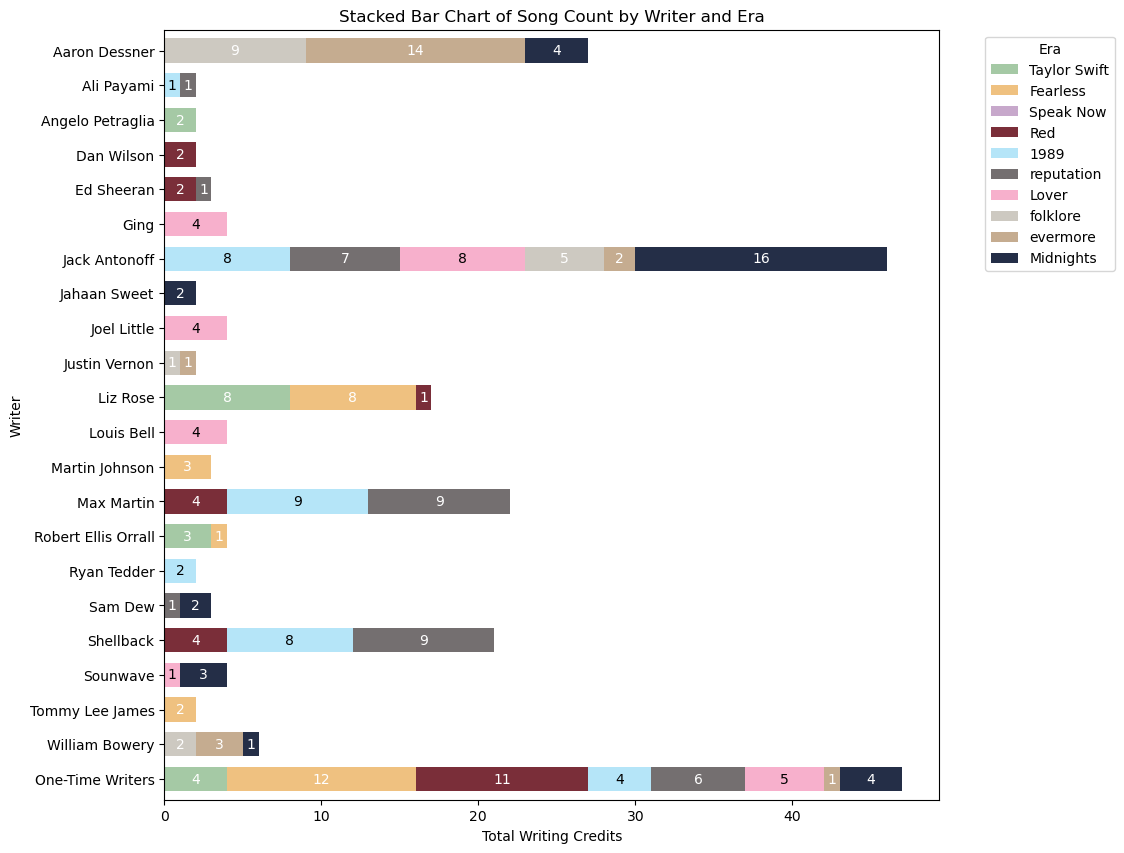

In [34]:
writers_barh = writers_pivot.plot(kind='barh',
                                  figsize=(10, 10),
                                  width=0.7,
                                  stacked=True, 
                                  color=[eras[col] for col in writers_pivot.keys()])
for container in writers_barh.containers:
    r = container.patches[0].get_facecolor()[0]
    g = container.patches[0].get_facecolor()[1]
    b = container.patches[0].get_facecolor()[2]

    color = 'white' if r * g * b < 0.5 else 'black'
    labels = [int(segment.get_width()) if segment.get_width() > 0 else '' for segment in container]    
    writers_barh.bar_label(container, labels=labels, label_type='center', color=color)
plt.xlabel('Total Writing Credits')
plt.ylabel('Writer')
plt.title('Stacked Bar Chart of Song Count by Writer and Era')
plt.legend(title='Era', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [130]:
connection.close()

In [32]:
for container in writers_barh.containers:
    print (container.patches[0].get_facecolor()[2])

0.6470588235294118
0.5019607843137255
0.796078431372549
0.2235294117647059
0.9725490196078431
0.4392156862745098
0.8
0.7568627450980392
0.5647058823529412
0.2784313725490196
